# MNSIT DATASET 

In [11]:
import avalanche

In [8]:
data = 'ccifar10'

In [9]:
import importlib
data = importlib.import_module(f"avalanche.benchmarks.classic.{data}")

In [10]:
data.SplitCIFAR10

<function avalanche.benchmarks.classic.ccifar10.SplitCIFAR10(n_experiences: int, *, first_exp_with_half_classes: bool = False, return_task_id=False, seed: Optional[int] = None, fixed_class_order: Optional[Sequence[int]] = None, shuffle: bool = True, class_ids_from_zero_in_each_exp: bool = False, class_ids_from_zero_from_first_exp: bool = False, train_transform: Optional[Any] = Compose(
    RandomCrop(size=(32, 32), padding=4)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
), eval_transform: Optional[Any] = Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
), dataset_root: Union[pathlib.Path, str, NoneType] = None) -> avalanche.benchmarks.scenarios.deprecated.new_classes.nc_scenario.NCScenario>

In [ ]:
from avalanche.benchmarks.classic import (
    SplitMNIST, SplitCIFAR10, SplitCIFAR110
)


In [53]:
benchmark = SplitMNIST(n_experiences=10, seed=1)

In [ ]:
# benchmark = PermutedMNIST(n_experiences=4, seed=1)

In [54]:
train_stream = benchmark.train_stream

In [55]:
# Than we can extract the parallel train and test streams
train_stream = benchmark.train_stream
test_stream = benchmark.test_stream

In [56]:
import numpy as np

In [57]:
def sample_xy(exp, n=1000, seed=0):
    rng = np.random.RandomState(seed)
    idx = rng.choice(len(exp.dataset), size=min(n, len(exp.dataset)), replace=False)
    Xs, ys = [], []
    for i in idx:
        x, y, *_ = exp.dataset[i]
        Xs.append(x.view(-1).cpu().numpy()); ys.append(int(y))
    return np.stack(Xs), np.array(ys)

In [58]:
stream = benchmark.train_stream  # or a list of NCExperience
Xs_raw, ys = [], []
for i, e in enumerate(stream):
    Xk, yk = sample_xy(e, n=1000, seed=100+i)
    Xs_raw.append(Xk); ys.append(yk)


In [66]:
# Fit PCA on first experience for consistent axes
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(Xs_raw[0])
Xs2 = [pca.transform(Xk) for Xk in Xs_raw]

In [61]:
import numpy as np, matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [62]:
allX = np.vstack(Xs2)

In [67]:
# Determine number of tasks (K) from ys
all_y = np.concatenate(ys) if len(ys) else np.array([], dtype=int)
K = int(all_y.max()) + 1 if all_y.size else 1

In [68]:
np.unique(all_y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

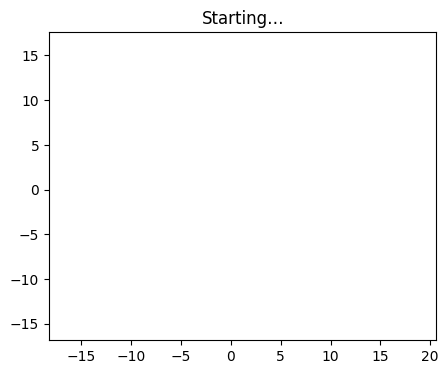

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(5,4))

# Determine label range across all frames
all_y = np.concatenate(ys) if len(ys) else np.array([], dtype=int)
if all_y.size == 0:
    vmin, vmax = 0, 1
else:
    vmin, vmax = int(all_y.min()), int(all_y.max())

# Create scatter with an empty c array to enable colormapping immediately
sc = ax.scatter([], [], s=6, alpha=0.85,
                c=np.array([], dtype=float),  # key: provide c at creation
                cmap="tab10", vmin=vmin, vmax=vmax)

# Axes limits from all data
allX = np.vstack(Xs2)
ax.set_xlim(allX[:,0].min()-1, allX[:,0].max()+1)
ax.set_ylim(allX[:,1].min()-1, allX[:,1].max()+1)

def init():
    sc.set_offsets(np.empty((0,2)))
    sc.set_array(np.array([], dtype=float))  # keep consistent dtype
    ax.set_title("Starting…")
    return sc,

def update(i):
    Xi = Xs2[i][:, :2]
    yi = np.asarray(ys[i], dtype=float).ravel()  # 1D, numeric
    sc.set_offsets(Xi)
    sc.set_array(yi)  # updates the colormapped values
    ax.set_title(f"Experience {i+1}")
    return sc,

ani = FuncAnimation(fig, update, frames=len(Xs2), init_func=init,
                    blit=False, interval=1200, repeat=True)
HTML(ani.to_jshtml())


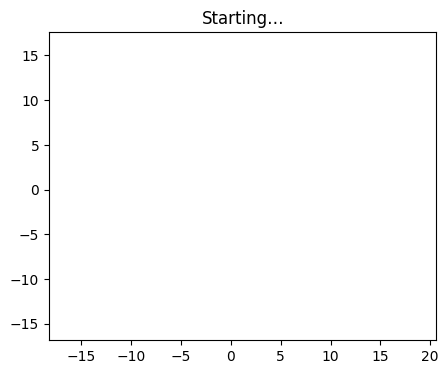

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(5,4))

# Colormap normalization based on all labels
all_y = np.concatenate(ys) if len(ys) else np.array([], dtype=int)
if all_y.size == 0:
    vmin, vmax = 0, 1
else:
    vmin, vmax = int(all_y.min()), int(all_y.max())

# Single scatter plot that will accumulate points
sc = ax.scatter([], [], s=6, alpha=0.9, 
                c=np.array([], dtype=float),
                cmap="tab10", vmin=vmin, vmax=vmax)

# Static limits from full dataset
allX = np.vstack(Xs2)
ax.set_xlim(allX[:,0].min()-1, allX[:,0].max()+1)
ax.set_ylim(allX[:,1].min()-1, allX[:,1].max()+1)

# Store cumulative data across frames
cumulative_X = []
cumulative_labels = []

def init():
    sc.set_offsets(np.empty((0,2)))
    sc.set_array(np.array([], dtype=float))
    ax.set_title("Starting…")
    # Clear cumulative storage
    cumulative_X.clear()
    cumulative_labels.clear()
    return sc,

def update(i):
    # Add current frame's data to cumulative storage
    cumulative_X.append(Xs2[i][:, :2])  # Add current positions
    cumulative_labels.extend(ys[i].tolist())  # Add current labels
    
    # Combine all accumulated points and labels
    all_points = np.vstack(cumulative_X)
    all_labels = np.array(cumulative_labels, dtype=float)
    
    # Update scatter with all accumulated data
    sc.set_offsets(all_points)
    sc.set_array(all_labels)
    
    ax.set_title(f"Experiences 1 to {i+1}")
    return sc,

ani = FuncAnimation(fig, update, frames=len(Xs2), init_func=init,
                    blit=False, interval=1200, repeat=True)

HTML(ani.to_jshtml())


Current experience of task  0
Classes in this task: [5]
This task contains 5421 training examples


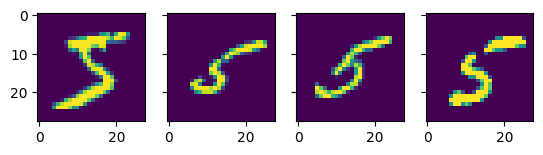

Current experience of task  1
Classes in this task: [6]
This task contains 5918 training examples


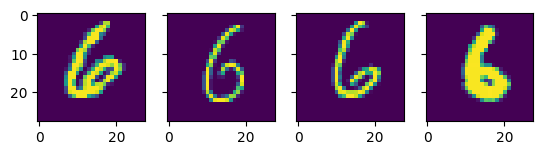

Current experience of task  2
Classes in this task: [1]
This task contains 6742 training examples


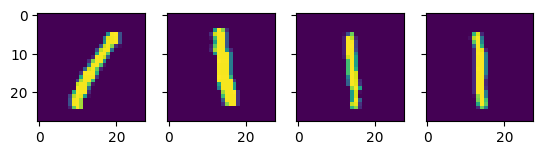

Current experience of task  3
Classes in this task: [2]
This task contains 5958 training examples


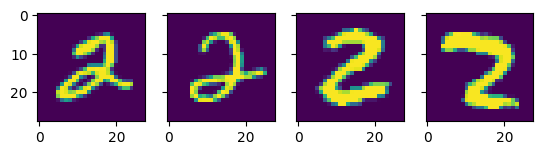

Current experience of task  4
Classes in this task: [0]
This task contains 5923 training examples


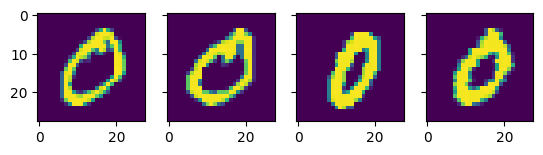

Current experience of task  5
Classes in this task: [8]
This task contains 5851 training examples


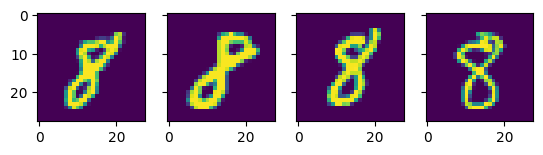

Current experience of task  6
Classes in this task: [9]
This task contains 5949 training examples


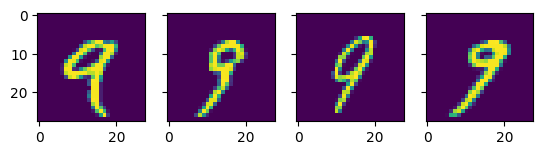

Current experience of task  7
Classes in this task: [3]
This task contains 6131 training examples


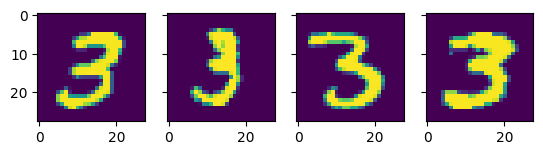

Current experience of task  8
Classes in this task: [7]
This task contains 6265 training examples


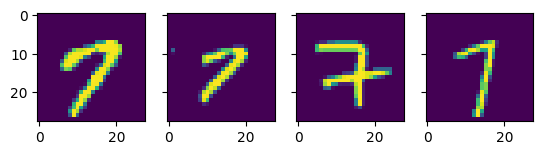

Current experience of task  9
Classes in this task: [4]
This task contains 5842 training examples


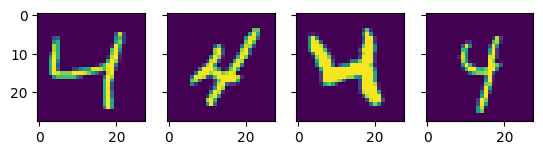

In [85]:
# iterating over the train stream
for experience in train_stream:
    print("Current experience of task ", experience.current_experience)
    print('Classes in this task:', experience.classes_in_this_experience)

    # The current Pytorch training set can be easily recovered through the 
    # experience
    current_training_set = experience.dataset
    print('This task contains', len(current_training_set), 'training examples')

    fig, axs = plt.subplots(1, 4, sharey=True)

    for ax, (img, *_) in zip(axs, current_training_set):
        ax.imshow(img.reshape(28,28))
    
    plt.show()